In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import math
from collections import defaultdict
import operator
import heapq


%matplotlib inline

## Camera Calibration

In [2]:
check_imgs = ["camera_cal/calibration"+str(i)+".jpg" for i in range(1,21)]
grid_sizes = [(9,5),(9,6),(9,6),(6,5),(7,6)]+ [(9,6)]*15

def calibration_matrix(imgs, grid_sizes):
    objpoints = []
    imgpoints = []
    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grid_size = grid_sizes[idx]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        # If found, add object points, image points
        if ret == True:
            objp = np.zeros((grid_size[0]*grid_size[1],3), np.float32)
            objp[:,:2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1,2)

            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx,dist)

mtx, dist = calibration_matrix(check_imgs,grid_sizes)

## Transformation to Birdview

In [3]:
img_size = (720,720)

def perspective_transformation(target_img_size):
    src = np.array([[592, 453], 
                    [695,453],
                    [970, 630],
                    [348, 630]], dtype = "float32")

    h_margin = 200
    top_margin = 200
    bottom_margin = 30
    dst = np.array([[h_margin, top_margin], 
                    [target_img_size[0] - h_margin, top_margin],
                    [target_img_size[0] - h_margin, target_img_size[1] - bottom_margin],
                    [h_margin, target_img_size[1] - bottom_margin]], dtype = "float32")
    return cv2.getPerspectiveTransform(src, dst)

M = perspective_transformation(img_size)
M_inv = np.linalg.inv(M)

## Define Mask

This is how the mask looks like on the birdview image


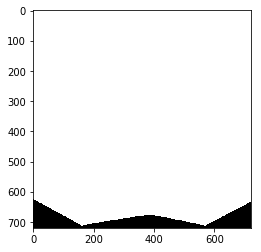

In [4]:
def region_of_interest(shape, vertices):
    #defining a blank mask to start with
    mask = np.zeros(shape,dtype=np.uint8)
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32),1)
    return mask
roi = region_of_interest((720,1280), [[300,420],[200,670],[700,600],[1150,670],[1000,420]])
roi = cv2.undistort(roi, mtx, dist, None, mtx)
roi = cv2.warpPerspective(roi, M, img_size, flags=cv2.INTER_LINEAR)
print("This is how the mask looks like on the birdview image")
plt.imshow(roi,cmap='gray')

This is how the mask looks like on the original image


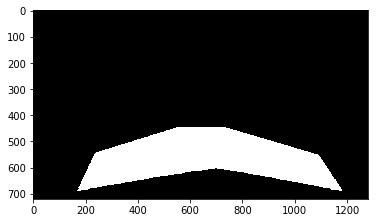

In [5]:
test = cv2.warpPerspective(roi, np.linalg.inv(M), (1280,720), flags=cv2.INTER_LINEAR)
print("This is how the mask looks like on the original image")
plt.imshow(test,cmap='gray')

## Filters

In [6]:
from Filters import topo_parabolic_bump_filter, abs_sobel_thresh, sob_filter, bump_filter

## Lane and LaneFinder
available in Lane.py and LaneFinder.py

In [67]:
mask_vertices = [[300,420],[200,670],[700,600],[1150,670],[1000,420]]
anchor_points = [[592, 453], [695,453],[970, 630],[348, 630]]
tranformed_image_size = (720,720)
PIX2XM = 3.7/330 #lane width is 3.7 meters, 430 pixels in image
PIX2YM = 3.0/60 #dash line is 3 meters long, 60 pixels in image
from LaneFinder import LaneFinder
############
import cv2
import numpy as np
from Lane import Lane

class LaneFinder:
    def __init__(self, original_image_size, mask_vertices, anchor_points, tranformed_image_size,
                 cali_mtx, cali_dist, convert_x, convert_y,
                 window_width=80, window_height=80, margin=100,
                 left_lane_bound=None, right_lane_bound=None,
                 left_lane_pixel_thres = 600, right_lane_pixel_thres=200,
                 smooth_window=5):
        self.original_image_size = original_image_size
        self.lane = Lane(tranformed_image_size, convert_x, convert_y, smooth_window)
        self.height = tranformed_image_size[0]
        self.width = tranformed_image_size[1]
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.level_num = (int)(tranformed_image_size[0]/window_height)
        self.window = np.ones(window_width) # Define window template
        self.channels = []
        [self.idx,self.idy] = np.meshgrid(range(tranformed_image_size[1]),
                                          range(tranformed_image_size[0]))
        self.calibration_matrix = cali_mtx
        self.calibration_dist = cali_dist

        self.poly_c0 = np.array([np.nan]*smooth_window)
        self.poly_c1 = np.array([np.nan]*smooth_window)
        self.poly_c2 = np.array([np.nan]*smooth_window)

        src = np.array(anchor_points, dtype = "float32")
        h_margin = 200
        top_margin = 200
        bottom_margin = 50
        dst = np.array([[h_margin, top_margin],
                        [tranformed_image_size[0] - h_margin, top_margin],
                        [tranformed_image_size[0] - h_margin, tranformed_image_size[1] - bottom_margin],
                        [h_margin, tranformed_image_size[1] - bottom_margin]], dtype = "float32")
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = np.linalg.inv(self.M)

        roi = np.zeros(original_image_size,dtype=np.uint8)
        cv2.fillPoly(roi, np.array([mask_vertices], dtype=np.int32),1)
        roi = cv2.undistort(roi, cali_mtx, cali_dist, None, cali_mtx)
        self.mask = cv2.warpPerspective(roi, self.M, tranformed_image_size, flags=cv2.INTER_LINEAR)

        # set left lane and right lane researching region individually
        if left_lane_bound is None:
            left_lane_bound = (int(self.width/8),int(self.width*3/8),int(self.height*3/4), self.height)
        if right_lane_bound is None:
            right_lane_bound = (int(self.width*5/8),int(self.width*7/8),int(self.height*1/8), self.height)
        self.lane_bound = [left_lane_bound, right_lane_bound]

        self.left_lane_pixel_thres = left_lane_pixel_thres
        self.right_lane_pixel_thres = right_lane_pixel_thres
        self.texts = [] # store center offset and curvature, as well as other info for debuging

    def window_mask(self, center, level):
        output = np.zeros((self.height,self.width))
        output[int(self.height-(level+1)*self.window_height):int(self.height-level*self.window_height),
               max(0,int(center-self.window_width/2)):min(int(center+self.window_width/2),self.width)] = 1
        return output

    def initial_window_finder(self, image, threshold,
                              left_bound, right_bound,
                              upper_bound, lower_bound):
        # Sum the bottom of the image with the given height vertically to get a 1d array
        # Each element in this array counts number of white pixels in that column
        v_sum = np.sum(image[upper_bound:lower_bound,left_bound:right_bound], axis=0)
        # Convolve the vertical image slice with the window template
        conv = np.convolve(self.window,v_sum)
        # the peak should have enough signals, and should stand out from the rests (not noise).
        if conv.max()>threshold:
            center = int(np.argmax(conv)-self.window.size/2 + left_bound)
            return center
        else:
            print("No enough pixels detected")

        return -1

    def channel_decompose(self, img, saturation_white_thresh=(0, 2),
                         saturation_yellow_thresh=(100, 180),
                         hue_thresh=(18, 25), value_thresh=(200, 255),
                         component_limit=6, min_area=1000,
                         ksize=15):


        # Convert to HLS color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        h_channel = hsv[:,:,0]
        s_channel = hsv[:,:,1]
        v_channel = hsv[:,:,2]

        v_binary = np.zeros_like(v_channel)
        v_binary[(v_channel>=value_thresh[0])&(v_channel<=value_thresh[1])] = 1
        #
        # r_channel = img[:,:,0]
        # r_binary = topo_parabolic_bump_filter(cv2.GaussianBlur(r_channel,(5,5),0),
        #                                       x_thresh=(0.9,1), min_area=1000, ksize=ksize)
        #
        # h_binary = np.zeros_like(h_channel)
        # h_binary[(h_channel>=hue_thresh[0])&(h_channel<=hue_thresh[1])] = 1
        #
        # sw_binary = np.zeros_like(s_channel)
        # sw_binary[(s_channel>=saturation_white_thresh[0])&(s_channel<=saturation_white_thresh[1])] = 1
        # sy_binary = np.zeros_like(s_channel)
        # sy_binary[(s_channel>=saturation_yellow_thresh[0])&(s_channel<=saturation_yellow_thresh[1])] = 1

        self.thresholds = [50]

        return [v_binary]

#         return [v_binary, r_binary,h_binary,sw_binary,sy_binary]
#         return [v_channel*v_binary, r_channel*r_binary,h_channel*h_binary,
#                 s_channel*sw_binary,s_channel*sy_binary]

    def prepare_channels(self, img):
        channels = self.channel_decompose(img)
        self.channels = [im*self.mask for im in channels] #ignore outside of masked region
        return len(channels)

    def find_window_per_level(self, image, center, level, threshold):
        # Find the best centroid by using past center as a reference
        min_index = max(center-self.margin, 0)
        max_index = min(center+self.margin, self.width)
        v_projection = np.sum(image[int(self.height-(level+1)*self.window_height):
                                    int(self.height-level*self.window_height),
                                    min_index:max_index],
                              axis=0)
        # convolve the window into the vertical slice of the image
        conv_signal = np.convolve(self.window, v_projection)
        peak_idx = np.argmax(conv_signal)
        # Update window center only if pixels in that slot exceed our threshold
        if (conv_signal[peak_idx]>threshold):
            # Use window_width/2 as offset because convolution signal reference is at right side of window,
            # not center of window
            center = peak_idx+min_index-int(self.window_width/2)
        return center

    def get_points_in_window(self, image, level, window_center):
        points = np.zeros_like(image)
        if window_center>=0:
            window_mask = self.window_mask(window_center,level)
            points = image*window_mask
        return points

    def init_lane_finder(self, side):
        idx = -1
        center = -1
        # search window center starting from the first channel
        # for the current channel, locate the bin with most pixels within the given bound
        # bounds are different for left lane and right, and are defined in the initializer.
        while center<0 and idx<len(self.channels)-1:
            idx += 1 # move to the next channel if cannot find a window with peak in this channel
            center = self.initial_window_finder(self.channels[idx],self.thresholds[idx],
                                                self.lane_bound[side][0], self.lane_bound[side][1],
                                                self.lane_bound[side][2], self.lane_bound[side][3])

        self.window_centroids[side].append((idx, center))
        points = np.zeros((self.height, self.width))
        if center>=0:
            # when a window with peak is found
            # slice the birdview image into several layers and search for peak in each layer.
            points = self.get_points_in_window(self.channels[idx], 0, center)
            for level in range(1,self.level_num):
                center = self.find_window_per_level(self.channels[idx], center,
                                                    level, self.thresholds[idx])
                level_points = self.get_points_in_window(self.channels[idx], level, center)
                points = np.maximum(points,level_points)
                self.window_centroids[side].append((idx, center))
        else:
            print("Could not find a peak window to start with in all channels")
        if side==0:
            (self.lane.left_y, self.lane.left_x) = np.where(points>0)
            print(self.lane.left_x.size)
            self.lane.polyfit_left()
        else:
            (self.lane.right_y, self.lane.right_x) = np.where(points>0)
            self.lane.polyfit_right()

    def tube_lane_finder(self, img, side):
        tube_mask = np.zeros_like(img)
        if side==0: # left lane
            search_radius = 10
            while (search_radius<self.margin and
                   self.lane.left_x.size<self.left_lane_pixel_thres):
                tube_mask[np.abs(self.idx-np.repeat([self.lane.left_fitx],
                                           self.width,axis=0).T)<search_radius]=1
                l_points = img*tube_mask
                (self.lane.left_y, self.lane.left_x) = np.where(l_points>0)
                search_radius += 10

            return self.lane.polyfit_left()

        else:  # right lane
            search_radius = 10
            while (search_radius<self.margin and
                   self.lane.right_x.size<self.right_lane_pixel_thres):
                tube_mask[np.abs(self.idx-np.repeat([self.lane.right_fitx],
                                               self.width,axis=0).T)<search_radius]=1
                r_points = img*tube_mask
                (self.lane.right_y, self.lane.right_x) = np.where(r_points>0)
                search_radius += 10

            return self.lane.polyfit_right()

    def draw_lane(self):
        # Draw the lane pixels and lane curve
        left_bound_idx, right_bound_idx = None, None
        if self.lane.left_x.size>0:
            # Make left lane pixels blue
            self.lane.canvas[self.lane.left_y,self.lane.left_x,2] = 255
        if self.lane.left_detected:
            # Draw polynomial
            self.lane.canvas[self.lane.ploty,self.lane.left_fitx,0:2] = 155
            left_bound_idx = np.repeat([self.lane.left_fitx],
                                        self.width,axis=0).T
        if self.lane.right_x.size>0:
            #right lane pixels red,
            self.lane.canvas[self.lane.right_y,self.lane.right_x,0] = 255
        if self.lane.right_detected:
            self.lane.canvas[self.lane.ploty,self.lane.right_fitx,0:2] = 155
#             self.lane.canvas[self.lane.ploty,self.lane.right_fitx,2] = 155
            right_bound_idx = np.repeat([self.lane.right_fitx], self.width,axis=0).T
        elif left_bound_idx is not None:
            right_bound_idx = left_bound_idx + self.lane.width

#         if (left_bound_idx is not None) and (right_bound_idx is not None):
#             self.lane.canvas[(self.idx-left_bound_idx>0)&(self.idx-right_bound_idx<0),1] = 50
        return self.lane.canvas

    def draw_windows(self):
        canvas = np.zeros((self.height,self.width))
        for side in [0,1]:
            level = -1
            for _, window_center in self.window_centroids[side]:
                level += 1
                canvas = np.maximum(canvas, self.window_mask(window_center,level))
        return canvas
    
    def draw_result(self, original_img):
        new_img = np.copy(original_img)
        font = cv2.FONT_HERSHEY_DUPLEX
        text_v_position = 70
        for text in self.texts:
            cv2.putText(new_img, text, (40, text_v_position),
                        font, 1.0, (200,255,155), 2, cv2.LINE_AA)
            text_v_position += 30

        return new_img

    def pipeline(self, img):
        # reset information for the current frame
        self.lane.reset_canvas()
        self.texts = []
        self.window_centroids = [[],[]]

        # undistort and apply perspective transformation to get birdview
        warped_img = cv2.undistort(img, self.calibration_matrix, self.calibration_dist,
                                   None, self.calibration_matrix)
        warped_img = cv2.warpPerspective(warped_img, self.M,
                                         (self.height,self.width),
                                         flags=cv2.INTER_LINEAR)

        # apply different filters to create candidate channels
        L = self.prepare_channels(warped_img)
#         return np.dstack((self.channels[0],self.channels[0],self.channels[0]))

        text = ''
        # If lane-line is detected from the previous frame,
        # then use tube_lane_finder
        if self.lane.left_detected and self.lane.left_fitx is not None:
            channel_left_idx = 0
            while channel_left_idx<L and (not self.tube_lane_finder(self.channels[channel_left_idx],0)):
                channel_left_idx += 1
            text += 'L channel:' + str(channel_left_idx)+' pix:'+ str(self.lane.left_x.size) + ', '
        else: # otherwise search from scratch
            text += 'L init '
            self.init_lane_finder(side=0)

        # same process applied to right lane-line
        if self.lane.right_detected and self.lane.right_fitx is not None:
            channel_right_idx = 0
            while channel_right_idx<L and (not self.tube_lane_finder(self.channels[channel_right_idx],1)):
                channel_right_idx += 1
            text += 'R channel:' + str(channel_right_idx)+' pix:'+ str(self.lane.right_x.size)
        else:
            text += 'R init '
            self.init_lane_finder(side=1)

        if len(text)>0: self.texts.append(text)

        if (self.lane.left_x.size>0) and (self.lane.right_x.size>0):
            # compute curvature and center offset
            (curvature, center_offset) = self.lane.analyze()
            self.texts.append("Curvature: "+"{:04.1f}".format(curvature) + 'm')
            self.texts.append("Distance from Center: "+"{:04.3f}".format(center_offset)+ 'm')

        return self.draw_lane()
        
        overlay = cv2.warpPerspective(self.draw_lane(), self.M_inv,
                                      (self.original_image_size[1],self.original_image_size[0]),
                                      flags=cv2.INTER_LINEAR)
        return self.draw_result(cv2.addWeighted(img, 1, overlay, 1, 0.0))


## Test on single image

(720, 1280, 3)
14954


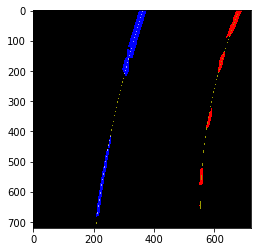

In [68]:
test_img = cv2.imread("test_images/test6.jpg")
print(test_img.shape)
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=80, window_height=80, margin=100)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
res = lane_finder.pipeline(test_img)
plt.imshow(res)
mpimg.imsave("test6_out0.png", res)

In [54]:
lane_finder.lane.left_x

array([284, 273, 273, 273, 273, 273, 273, 255, 255, 255, 255, 255, 255,
       239, 239, 239, 239, 239, 239, 226, 226, 226])

In [55]:
lane_finder.window_centroids

[[(0, 189),
  (0, 266),
  (0, 279),
  (0, 295),
  (0, 313),
  (0, 324),
  (0, 324),
  (0, 324),
  (0, 324)],
 [(0, 554),
  (0, 579),
  (0, 592),
  (0, 599),
  (0, 599),
  (0, 634),
  (0, 634),
  (0, 675),
  (0, 675)]]

## Test on project video

In [ ]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'project_video.mp4'
output = input_vid[:-4]+"_output.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)


In [ ]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'challenge_video.mp4'
output = input_vid[:-4]+"_overlay_polyfinder_curvature.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

In [ ]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'harder_challenge_video.mp4'
output = input_vid[:-4]+"_overlay_polyfinder_curvature.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

In [ ]:
from moviepy.editor import *

clip = (VideoFileClip("project_video_channels/project_video_channel_0.mp4")
        .resize(0.2))
clip.speedx(3).write_gif("channel0.gif")

In [ ]:
clip = VideoFileClip('myanimation.gif') # can be gif or movie
for frame in clip.iter_frames():
    mpimg.imsave("channel0.png",frame)
    break